In [1]:
import xarray as xr
import numpy as np 
import pandas as pd
import metpy.calc as mpc
from metpy.units import units

import matplotlib.pyplot as plt 


## Read in data

In [2]:
# Define file names 
dataDir  = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/'

z3file   = dataDir+'daily/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.2000_Z3.nc'
varsFile = dataDir+'daily/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.2000_RiVars.nc'
topoFile = dataDir+'fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
pressFile = dataDir+'daily/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.2000_PresLevs.nc'


In [3]:
# Open files into datasets 
z3_ds         = xr.open_dataset(z3file, decode_times=True)
z3_ds['time'] = z3_ds.indexes['time'].to_datetimeindex()

varsDS         = xr.open_dataset(varsFile, decode_times=True)
varsDS['time'] = varsDS.indexes['time'].to_datetimeindex()

pressDS         = xr.open_dataset(pressFile, decode_times=True)
pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()

topo_ds         = xr.open_dataset(topoFile, decode_times=True)


<ipython-input-3-0c83a03feec1>:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  z3_ds['time'] = z3_ds.indexes['time'].to_datetimeindex()
<ipython-input-3-0c83a03feec1>:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  varsDS['time'] = varsDS.indexes['time'].to_datetimeindex()
<ipython-input-3-0c83a03feec1>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
 

In [6]:
# Limit to levels with pressures >850.0 hPa 
iLev = np.where(z3_ds.lev.values > 850.0)[0]

z3_ds   = z3_ds.isel(lev=iLev)
varsDS  = varsDS.isel(lev=iLev)
pressDS = pressDS.isel(lev=iLev)


In [7]:
# Read in a land mask at the same resolution 
testName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/f.e20.FHIST.f09_f09.cesm2_1.001.clm2.h0.1989-12.nc'
testDF   = xr.open_dataset(testName)

# Make land mask
landMask              = testDF.landmask.values
landMask[landMask==0] = np.nan

np.shape(landMask)

(192, 288)

In [8]:
# Get height (above ground level)
Z3   = z3_ds.Z3.values*landMask
PHIS = topo_ds.PHIS.values*landMask

# Convert geopotential into geopotential height of surface
PHIS = PHIS/9.81

# Force PHIS to have same dimensions as Z3 
PHISnew1 = np.repeat(PHIS[np.newaxis, :,:],np.shape(Z3)[1],axis=0)
PHISnew  = np.repeat(PHISnew1[np.newaxis,:,:,:],np.shape(Z3)[0],axis=0)
print('Shape of Z3:   ', np.shape(Z3))
print('Shape of PHIS: ', np.shape(PHISnew))

# Height agl is then just Z3 - PHISnew
z_agl = (Z3 - PHISnew) * units.meters


Shape of Z3:    (360, 7, 192, 288)
Shape of PHIS:  (360, 7, 192, 288)


In [9]:
# Get potential temperature 
P = (pressDS.PRESSURE.values*landMask) * units('Pa')
T = (varsDS.T.values*landMask)         * units('K')

potTemp = mpc.potential_temperature(P,T)


In [10]:
np.shape(potTemp)

(360, 7, 192, 288)

In [11]:
np.shape(varsDS.lat.values)

(192,)

In [12]:
# Clear variables from memory that aren't needed anymore
del PHISnew
del PHIS 
del Z3 
del P
del T 
del pressDS
del z3_ds
del topo_ds
del testDF


In [14]:
# Compute gradient richardson number
U = (varsDS.U.values) * units('m/s')
V = (varsDS.V.values) * units('m/s')

print('Computing Ri...')

# Ri = np.full([], np.nan)

# for iLat in range(len(varsDS.lat.values)):
#     for iLon in range(len(varsDS.lon.values)):
Ri = mpc.gradient_richardson_number(z_agl, potTemp, U, V, 1)


Computing Ri...


In [15]:
np.shape(Ri)

(360, 7, 192, 288)

<ipython-input-25-2a4e68483383>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(varsDS.lon.values,varsDS.lat.values,np.squeeze(Ri[100,-1,:,:]),


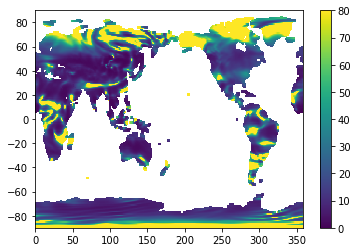

In [25]:
plt.pcolormesh(varsDS.lon.values,varsDS.lat.values,np.squeeze(Ri[100,-1,:,:]), 
                vmax=80,vmin=0)
plt.colorbar()

In [27]:
iLim = np.where(Ri<=0.25)[0]
iLim

array([  0,   0,   0, ..., 359, 359, 359])